## Visualizations

In [183]:
import pandas as pd
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import wordcloud
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [184]:
by_isrc = pd.read_csv('by_isrc_oldest.csv')

In [185]:
by_isrc.head().T

,0,1,2,3,4
isrc,AEA040700577,AEA040700578,AEA040700579,AEA040700580,AEA040700581
genres,"['j-pop', 'jazz', 'pop']","['groove', 'j-pop', 'jazz', 'pop']","['groove', 'j-pop', 'jazz', 'pop']","['groove', 'j-pop', 'jazz', 'pop']","['groove', 'j-pop', 'jazz', 'pop', 'pop']"
name,Bala Wala Chi,Houdou Nisbi,Nafs Al Sheghlat,Yalla Kichou Barra,Ma Tfel
artists,Ziad Rahbani,Ziad Rahbani,Ziad Rahbani,Ziad Rahbani,Ziad Rahbani
album,Houdou Nisbi,Houdou Nisbi,Houdou Nisbi,Houdou Nisbi,Houdou Nisbi
release_date,1985-01-01,1985-01-01,1985-01-01,1985-01-01,1985-01-01
release_date_precision,day,day,day,day,day
uri,spotify:track:0fylgLeNObjVvwhd8caHqX,spotify:track:0yMFpBNCYXqwwOAg23bC8a,spotify:track:6G8l1kI8QlTD0UDIak5F8H,spotify:track:21g76Lq5Jg4QvfTDvi4PlH,spotify:track:0pKxrkFh8fxPKpkO29MYmi
spotify_id,0fylgLeNObjVvwhd8caHqX,0yMFpBNCYXqwwOAg23bC8a,6G8l1kI8QlTD0UDIak5F8H,21g76Lq5Jg4QvfTDvi4PlH,0pKxrkFh8fxPKpkO29MYmi
chart_power,NaN,NaN,NaN,NaN,NaN


## Find the biggest genres

In [186]:
df = pd.read_csv('data.csv')
df.drop_duplicates(inplace=True)

In [187]:
ct = pd.crosstab(df['isrc'], df['genres'])
# ct.reset_index(inplace=True)
ct = ct.applymap(lambda x: 1 if x > 1 else x)
ct.reset_index(inplace=True)

In [188]:
ct_sum = ct.sum()

In [189]:
ct_sum_df = pd.DataFrame(ct_sum)

In [190]:
ct_sum_df.drop(index='isrc', inplace=True)

In [191]:
ct_sum_df.rename(columns={0: 'count'}, inplace=True)

In [192]:
sorted_genres = ct_sum_df.sort_values(by='count', ascending=False).index.to_list()

In [194]:
ct_sum_df.sort_values(by='count', ascending=False)[0:15]

,count
genres,
pop,118762
rock,93935
classical,93628
german,37752
jazz,30068
folk,30053
punk,24275
metal,15761
country,15546


Biggest genres is pop. Hard-rock is only on the 12th place.

Count occurences of the top genres per year

In [195]:
by_isrc_year = by_isrc.copy()
by_isrc_year = by_isrc_year[['year', 'isrc']]
by_isrc_year = by_isrc_year.merge(ct, on=['isrc'], how='left')
by_isrc_year.set_index('year', inplace=True)

genres_by_year = by_isrc_year[sorted_genres[:50]] #used for wordcloud
genres_by_year = genres_by_year.groupby('year').sum()
genres_by_year.index = genres_by_year.index.astype(str)

by_isrc_year = by_isrc_year[sorted_genres[:10]]
by_isrc_year = by_isrc_year.groupby('year').sum()
by_isrc_year.index = by_isrc_year.index.astype(str)

In [196]:
by_isrc_year

,pop,rock,classical,german,jazz,folk,punk,metal,country,french
year,,,,,,,,,,
1980,11523,8459,5302,2248,2601,3065,2165,737,1804,888
1981,10277,8302,5424,2471,2117,2177,2455,823,1711,1139
1982,10359,7874,5393,2185,2239,41,2417,803,44,962
1983,10033,8292,6917,3433,1998,2416,2366,1114,1483,1129
1984,12202,8837,7017,3047,2250,2564,2419,1532,1265,1365
1985,11372,8721,7751,3443,2450,2779,2251,1612,1640,1193
1986,11430,9258,9244,3824,2956,3772,2322,1807,1628,1278
1987,12310,10706,12349,4458,3599,4267,2510,2293,1876,1498
1988,13809,11045,16545,6465,4639,4272,2736,2380,1930,2167


## Development of features over the years

In [197]:
df = by_isrc.copy()

In [198]:
df.head(2).T

,0,1
isrc,AEA040700577,AEA040700578
genres,"['j-pop', 'jazz', 'pop']","['groove', 'j-pop', 'jazz', 'pop']"
name,Bala Wala Chi,Houdou Nisbi
artists,Ziad Rahbani,Ziad Rahbani
album,Houdou Nisbi,Houdou Nisbi
release_date,1985-01-01,1985-01-01
release_date_precision,day,day
uri,spotify:track:0fylgLeNObjVvwhd8caHqX,spotify:track:0yMFpBNCYXqwwOAg23bC8a
spotify_id,0fylgLeNObjVvwhd8caHqX,0yMFpBNCYXqwwOAg23bC8a
chart_power,NaN,NaN


In [199]:
songs_per_year = df.copy()
songs_per_year = songs_per_year[['year', 'popularity', 'danceability', 'energy',
                                 'key', 'loudness', 'mode', 'speechiness',
                                 'acousticness', 'instrumentalness', 'liveness',
                                 'valence', 'tempo', 'duration_ms',
                                 'time_signature']]
songs_per_year['count'] = -1
songs_per_year = songs_per_year.groupby("year").agg({
    "popularity": 'mean',
    'danceability': 'mean', 
    'energy': 'mean',
    'key': 'mean', 
    'loudness': 'mean', 
    'mode': 'mean', 
    'speechiness': 'mean',
    'acousticness': 'mean', 
    'instrumentalness': 'mean', 
    'liveness': 'mean',
    'valence': 'mean', 
    'tempo': 'mean', 
    'duration_ms': 'mean',
    'time_signature': 'mean',
    'count': 'count'
})
songs_per_year.reset_index(inplace=True)

In [200]:
songs_per_year['duration_min'] = songs_per_year['duration_ms'] / (1000 * 60)

In [201]:
songs_per_year.head(10)

,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,count,duration_min
0,1980,6.932103,0.499812,0.485525,5.110445,-12.356653,0.703678,0.065002,0.521989,0.169238,0.220967,0.543921,118.259726,247998.407916,3.830705,35701,4.133307
1,1981,7.112235,0.501099,0.488608,5.164865,-12.559169,0.699801,0.068562,0.511205,0.175626,0.222056,0.541400,118.658803,244699.429525,3.832266,33118,4.078324
2,1982,7.169674,0.503354,0.486809,5.193071,-12.731032,0.698866,0.077487,0.507867,0.175538,0.221643,0.531725,118.373840,247427.740306,3.835526,31926,4.123796
3,1983,7.047373,0.495283,0.471217,5.186754,-13.219378,0.687359,0.065915,0.516330,0.193409,0.217015,0.519328,117.784345,251536.693328,3.830344,34682,4.192278
4,1984,7.346757,0.491733,0.477950,5.207964,-13.240091,0.674151,0.064660,0.512988,0.188150,0.222164,0.507015,117.703958,249410.156878,3.837688,37545,4.156836
5,1985,7.163784,0.488324,0.470269,5.156586,-13.452114,0.684718,0.061279,0.523986,0.203092,0.215998,0.506548,117.184774,255583.193630,3.833289,37928,4.259720
6,1986,6.717974,0.474060,0.456206,5.176228,-13.903385,0.686777,0.062151,0.543401,0.219038,0.211249,0.486566,116.233584,256471.286957,3.829770,42184,4.274521
7,1987,6.634905,0.469873,0.443336,5.180522,-14.392384,0.692525,0.061195,0.553069,0.238068,0.207147,0.473718,116.127546,259072.147444,3.819021,50365,4.317869
8,1988,6.138412,0.464916,0.428971,5.169508,-14.948866,0.687010,0.062721,0.565367,0.260287,0.210766,0.472932,115.397637,262048.766115,3.810233,58593,4.367479
9,1989,6.067652,0.467819,0.418770,5.191640,-15.100176,0.691717,0.064646,0.572174,0.254533,0.206904,0.466538,115.049823,261012.425156,3.807026,65216,4.350207


In [202]:
songs_per_year.columns

Index(['year', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'count',
       'duration_min'],
      dtype='object')

In [203]:
songs_per_year = songs_per_year.astype({'year': str})

In [204]:
alt.Chart(songs_per_year).mark_bar().encode(
    alt.X("year"),
    alt.Y("count")
)

alt.Chart(...)

In [205]:
features = ['popularity', 'danceability', 'energy',
            'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'duration_min',
            'time_signature']

In [206]:
songs_per_year.head()

,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,count,duration_min
0,1980,6.932103,0.499812,0.485525,5.110445,-12.356653,0.703678,0.065002,0.521989,0.169238,0.220967,0.543921,118.259726,247998.407916,3.830705,35701,4.133307
1,1981,7.112235,0.501099,0.488608,5.164865,-12.559169,0.699801,0.068562,0.511205,0.175626,0.222056,0.541400,118.658803,244699.429525,3.832266,33118,4.078324
2,1982,7.169674,0.503354,0.486809,5.193071,-12.731032,0.698866,0.077487,0.507867,0.175538,0.221643,0.531725,118.373840,247427.740306,3.835526,31926,4.123796
3,1983,7.047373,0.495283,0.471217,5.186754,-13.219378,0.687359,0.065915,0.516330,0.193409,0.217015,0.519328,117.784345,251536.693328,3.830344,34682,4.192278
4,1984,7.346757,0.491733,0.477950,5.207964,-13.240091,0.674151,0.064660,0.512988,0.188150,0.222164,0.507015,117.703958,249410.156878,3.837688,37545,4.156836


In [207]:
# Create the initial scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=songs_per_year['year'],
    y=songs_per_year['duration_ms'],
    #mode='markers',
    name='Duration (ms)'
))

# Define the dropdown menu options
dropdown_options = [
    {'label': 'Duration (ms)', 'value': 'duration_ms'},
    {'label': 'Popularity', 'value': 'popularity'},
    {'label': 'Danceability', 'value': 'danceability'},
    {'label': 'Energy', 'value': 'energy'},
    {'label': 'Key', 'value': 'key'},
    {'label': 'Loudness', 'value': 'loudness'},
    {'label': 'Mode', 'value': 'mode'},
    {'label': 'Speechiness', 'value': 'speechiness'},
    {'label': 'Acousticness', 'value': 'acousticness'},
    {'label': 'Instrumentalness', 'value': 'instrumentalness'},
    {'label': 'Liveness', 'value': 'liveness'},
    {'label': 'Valence', 'value': 'valence'},
    {'label': 'Tempo', 'value': 'tempo'},
    {'label': 'Time Signature', 'value': 'time_signature'},
    {'label': 'Count', 'value': 'count'},
    {'label': 'Duration (min)', 'value': 'duration_min'}
]

# Create the dropdown menu
dropdown_menu = go.layout.Updatemenu(
    buttons=list([
        dict(
            args=[
                {'y': [songs_per_year[option['value']]]}, 
                {'yaxis': {'title': option['label'].capitalize()}}
            ],
            label=option['label'],
            method='update'
        )
        for option in dropdown_options
    ]),
    direction='down',
    showactive=True,
)

# Update the layout with dropdown menu and initial y-axis title
fig.update_layout(
    height = 800,
    updatemenus=[dropdown_menu],
    yaxis_title='Duration (ms)',
    xaxis_title='year',
    title='Development of features',
    showlegend=True
)

fig.show()

In [208]:
songs_per_year_genres = songs_per_year.merge(by_isrc_year, on='year', how='right')

#Create the initial scatter plot for genre 'pop'
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=songs_per_year_genres['year'],
    y=songs_per_year_genres['duration_ms'],
    #mode='line',
    name='pop',
    visible=True
))

# Add separate scatter plots for each genre
genres = ['rock', 'classical', 'german', 'jazz', 'folk', 'punk', 'metal', 'country', 'french']

for genre in genres:
    fig.add_trace(go.Scatter(
        x=songs_per_year_genres['year'],
        y=songs_per_year_genres['duration_ms'],
        #mode='line',
        name=genre,
        visible=False
    ))

# Create the dropdown menu for y-axis selection
dropdown_options = ['duration_ms', 'popularity', 'danceability', 'energy', 'key', 'loudness',
                    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                    'valence', 'tempo', 'duration_min']

dropdown_menu = go.layout.Updatemenu(
    buttons=list([
        dict(
            args=[{'y': [songs_per_year_genres[option]]}],
            #label=option.capitalize(),
            method='update'
        )
        for option in dropdown_options
    ]),
    direction='down',
    showactive=True,
)

# Create the legend to toggle genre visibility
legend = dict(
    title='Genre',
    orientation='h',
    y=1.1,
    x=0.5,
    xanchor='center',
    bgcolor='rgba(255, 255, 255, 0.5)'
)

# Update the layout with dropdown menu, legend, and initial y-axis title
fig.update_layout(
    height = 800,
    updatemenus=[dropdown_menu],
    legend=legend,
    yaxis_title='Duration (ms)',
    title='Song Duration by Genre',
    xaxis_title='Year',
    showlegend=True
)

# Add custom buttons to toggle genre visibility in the legend
for i, genre in enumerate(genres):
    button = dict(
        label=genre.capitalize(),
        method='update',
        args=[{'visible': [True if j == i+1 else False for j in range(len(genres)+1)]}]
    )
    fig.update_traces(showlegend=True if genre == 'pop' else False, selector=dict(name=genre))
    fig.update_layout({'updatemenus': [{'buttons': [button]}]})

#fig.show()

## Development of genres of the years

In [209]:
genres_by_year

,pop,rock,classical,german,jazz,folk,punk,metal,country,french,...,dance,indian,salsa,industrial,power-pop,pop-film,rock-n-roll,electro,hip-hop,rockabilly
year,,,,,,,,,,,,,,,,,,,,,
1980,11523,8459,5302,2248,2601,3065,2165,737,1804,888,...,227,203,492,112,344,230,270,268,48,239
1981,10277,8302,5424,2471,2117,2177,2455,823,1711,1139,...,282,365,340,175,302,182,226,246,27,215
1982,10359,7874,5393,2185,2239,41,2417,803,44,962,...,8,326,312,237,238,292,251,0,50,234
1983,10033,8292,6917,3433,1998,2416,2366,1114,1483,1129,...,528,318,269,201,197,276,162,191,45,246
1984,12202,8837,7017,3047,2250,2564,2419,1532,1265,1365,...,272,287,292,313,288,334,333,310,99,182
1985,11372,8721,7751,3443,2450,2779,2251,1612,1640,1193,...,479,364,386,281,230,396,164,255,93,273
1986,11430,9258,9244,3824,2956,3772,2322,1807,1628,1278,...,314,270,248,424,292,350,229,229,250,247
1987,12310,10706,12349,4458,3599,4267,2510,2293,1876,1498,...,469,426,289,371,454,235,305,252,413,250
1988,13809,11045,16545,6465,4639,4272,2736,2380,1930,2167,...,390,507,443,423,299,357,265,669,909,415


In [280]:
genres_by_year = genres_by_year.reset_index()

AttributeError: 'dict' object has no attribute 'reset_index'

In [211]:
column_list = genres_by_year.columns.tolist()
id_vars_list = column_list[:1]
print(id_vars_list)

['year']


In [212]:
df_new = pd.melt(genres_by_year, id_vars=id_vars_list, 
             value_name="count")
df_new=df_new.rename(columns={"variable": "genres"})
df_new

,year,genres,count
0,1980,pop,11523
1,1981,pop,10277
2,1982,pop,10359
3,1983,pop,10033
4,1984,pop,12202
...,...,...,...
495,1985,rockabilly,273
496,1986,rockabilly,247
497,1987,rockabilly,250
498,1988,rockabilly,415


### Word Cloud for all Genres over 10 Years

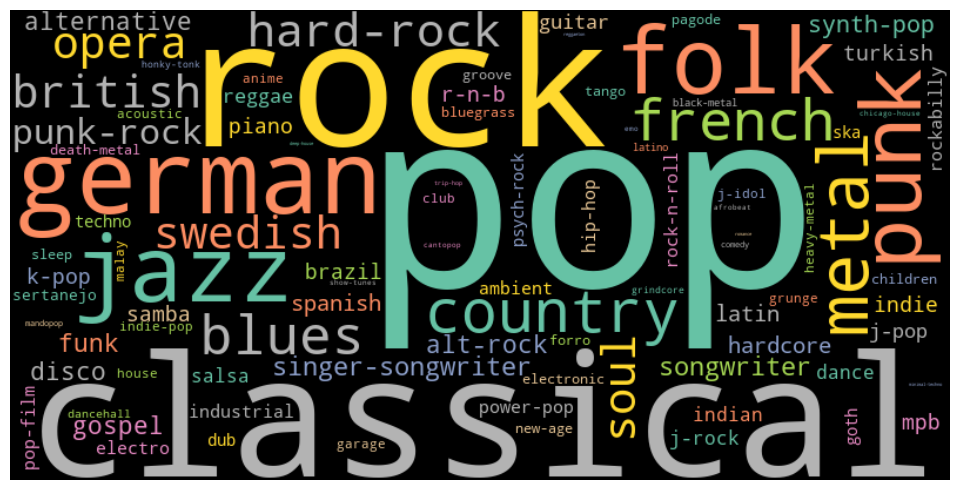

In [303]:
genres_count = ct_sum_df.sort_values(by='count', ascending=False)
genres_count = genres_count.to_dict()

cloud = wordcloud.WordCloud(width=800, height=400, background_color='black',colormap='Set2').generate_from_frequencies(genres_count['count'])
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [279]:
genres_by_year = genres_by_year.set_index('year')
genres_by_year = genres_by_year.to_dict('index')

AttributeError: 'dict' object has no attribute 'set_index'

### Word Cloud for Top 50 Genres per Year 

In [301]:
dropdown = widgets.Dropdown(options = genres_by_year,
                                value=genres_by_year['1980'],
                                 description= "year" )

def wc(df):
    clear_output(wait=True)
    cloud = wordcloud.WordCloud(width=700, height=400, background_color='black',colormap='Set2').generate_from_frequencies(df)
    plt.figure(figsize=(9, 9))
    plt.imshow(cloud)
    plt.tight_layout()
    plt.axis("off")
widgets.interact(wc,df=dropdown)

interactive(children=(Dropdown(description='year', options={'1980': {'pop': 11523, 'rock': 8459, 'classical': …

<function __main__.wc(df)>

In [216]:
slider_step

{'args': [['1989'],
  {'frame': {'duration': 300, 'redraw': False},
   'mode': 'immediate',
   'transition': {'duration': 300}}],
 'label': '1989',
 'method': 'animate'}

In [217]:
features = sorted_genres[:10]

In [218]:
dev_genres_df = by_isrc_year.reset_index()

In [219]:
dev_genres_df

,year,pop,rock,classical,german,jazz,folk,punk,metal,country,french
0,1980,11523,8459,5302,2248,2601,3065,2165,737,1804,888
1,1981,10277,8302,5424,2471,2117,2177,2455,823,1711,1139
2,1982,10359,7874,5393,2185,2239,41,2417,803,44,962
3,1983,10033,8292,6917,3433,1998,2416,2366,1114,1483,1129
4,1984,12202,8837,7017,3047,2250,2564,2419,1532,1265,1365
5,1985,11372,8721,7751,3443,2450,2779,2251,1612,1640,1193
6,1986,11430,9258,9244,3824,2956,3772,2322,1807,1628,1278
7,1987,12310,10706,12349,4458,3599,4267,2510,2293,1876,1498
8,1988,13809,11045,16545,6465,4639,4272,2736,2380,1930,2167
9,1989,15447,12441,17686,6178,5212,4700,2634,2660,2165,2598


In [220]:
# Create the initial scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dev_genres_df['year'],
    y=dev_genres_df['pop'],
    #mode='markers',
    name='Pop'
))

# Create the dropdown menu
dropdown_menu = go.layout.Updatemenu(
    buttons=list([
        dict(
            args=[
                {'y': [dev_genres_df[option]]}, 
                {'yaxis': {'title': option.capitalize()}}
            ],
            label=option,
            method='update'
        )
        for option in features
    ]),
    direction='down',
    showactive=True,
)

# Update the layout with dropdown menu and initial y-axis title
fig.update_layout(
    height = 800,
    updatemenus=[dropdown_menu],
    yaxis_title='pop',
    xaxis_title='year',
    title='Development of features'
)

fig.show()

## Add the genres to the features

In [221]:
df.head()

,isrc,genres,name,artists,album,release_date,release_date_precision,uri,spotify_id,chart_power,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
0,AEA040700577,"['j-pop', 'jazz', 'pop']",Bala Wala Chi,Ziad Rahbani,Houdou Nisbi,1985-01-01,day,spotify:track:0fylgLeNObjVvwhd8caHqX,0fylgLeNObjVvwhd8caHqX,NaN,...,1,0.0418,0.952,0.382,0.2370,0.371,157.168,207560,3,1985
1,AEA040700578,"['groove', 'j-pop', 'jazz', 'pop']",Houdou Nisbi,Ziad Rahbani,Houdou Nisbi,1985-01-01,day,spotify:track:0yMFpBNCYXqwwOAg23bC8a,0yMFpBNCYXqwwOAg23bC8a,NaN,...,0,0.0308,0.814,0.951,0.0827,0.495,128.386,272240,3,1985
2,AEA040700579,"['groove', 'j-pop', 'jazz', 'pop']",Nafs Al Sheghlat,Ziad Rahbani,Houdou Nisbi,1985-01-01,day,spotify:track:6G8l1kI8QlTD0UDIak5F8H,6G8l1kI8QlTD0UDIak5F8H,NaN,...,1,0.0449,0.954,0.887,0.2710,0.304,82.630,160093,4,1985
3,AEA040700580,"['groove', 'j-pop', 'jazz', 'pop']",Yalla Kichou Barra,Ziad Rahbani,Houdou Nisbi,1985-01-01,day,spotify:track:21g76Lq5Jg4QvfTDvi4PlH,21g76Lq5Jg4QvfTDvi4PlH,NaN,...,1,0.0341,0.430,0.838,0.1240,0.656,102.485,155667,4,1985
4,AEA040700581,"['groove', 'j-pop', 'jazz', 'pop', 'pop']",Ma Tfel,Ziad Rahbani,Houdou Nisbi,1985-01-01,day,spotify:track:0pKxrkFh8fxPKpkO29MYmi,0pKxrkFh8fxPKpkO29MYmi,NaN,...,0,0.0436,0.749,0.941,0.1150,0.752,150.656,265173,4,1985


In [222]:
scaler = MinMaxScaler()
by_isrc_scaled = by_isrc.copy()
by_isrc_scaled.set_index('isrc', inplace=True)
by_isrc_scaled = by_isrc_scaled[['danceability', 'energy',
                       'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness',
                       'valence', 'time_signature', 'tempo']]
by_isrc_scaled = pd.DataFrame(scaler.fit_transform(by_isrc_scaled), columns=by_isrc_scaled.columns, index = by_isrc_scaled.index)
by_isrc_scaled.reset_index(inplace=True)

In [223]:
by_isrc_genres = ct.merge(by_isrc_scaled, on=['isrc'], how='right')

In [224]:
by_isrc_genres.head()

,isrc,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo
0,AEA040700577,0,0,0,0,0,0,0,0,0,...,0.818182,0.620601,1.0,0.043182,0.955823,0.382,0.2370,0.371,0.6,0.638375
1,AEA040700578,0,0,0,0,0,0,0,0,0,...,0.636364,0.618011,0.0,0.031818,0.817269,0.951,0.0827,0.495,0.6,0.521470
2,AEA040700579,0,0,0,0,0,0,0,0,0,...,0.272727,0.578544,1.0,0.046384,0.957831,0.887,0.2710,0.304,0.8,0.335621
3,AEA040700580,0,0,0,0,0,0,0,0,0,...,0.454545,0.626845,1.0,0.035227,0.431727,0.838,0.1240,0.656,0.8,0.416267
4,AEA040700581,0,0,0,0,0,0,0,0,0,...,0.454545,0.631776,0.0,0.045041,0.752008,0.941,0.1150,0.752,0.8,0.611925


## Create Radar Chart for the top 10 genres

In [225]:
sorted_genres[:10]

['pop',
 'rock',
 'classical',
 'german',
 'jazz',
 'folk',
 'punk',
 'metal',
 'country',
 'french']

In [226]:
fig = go.Figure()
for genre in sorted_genres[:10]:
    df_copy = by_isrc_genres.copy()
    df_copy = df_copy[df_copy[genre] == 1]
    df_copy = df_copy[['danceability', 'energy',
                       'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness',
                       'valence', 'time_signature', 'tempo', 'danceability']]
    df_radar = pd.DataFrame(df_copy.mean(), columns=['mean'])
    df_radar.reset_index(inplace=True)
    df_radar.rename(columns={"index":"feature"}, inplace=True)

    fig.add_trace(go.Scatterpolar(
        r = df_radar['mean'],
        theta = df_radar['feature'],
        mode = 'lines',
        fill = 'none',
        name = genre
    ))

In [227]:
fig.update_layout(
    height = 800
)
fig.show()

#### Popularity of Artists

In [308]:
def wordcloud_artists(counts):
    cloud = wordcloud.WordCloud(width=800, height=400, background_color='black',colormap='Set2').generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [273]:
artists_popularity = df.groupby("artists").sum().sort_values('popularity',ascending=False)
artists_popularity = artists_popularity.reset_index()
artists_popularity = artists_popularity[['artists', 'popularity']]

In [274]:
artists_popularity.head(5)

,artists,popularity
0,Metallica,8031
1,The Smiths,5841
2,The Cure,5477
3,R.E.M.,5470
4,U2,5338


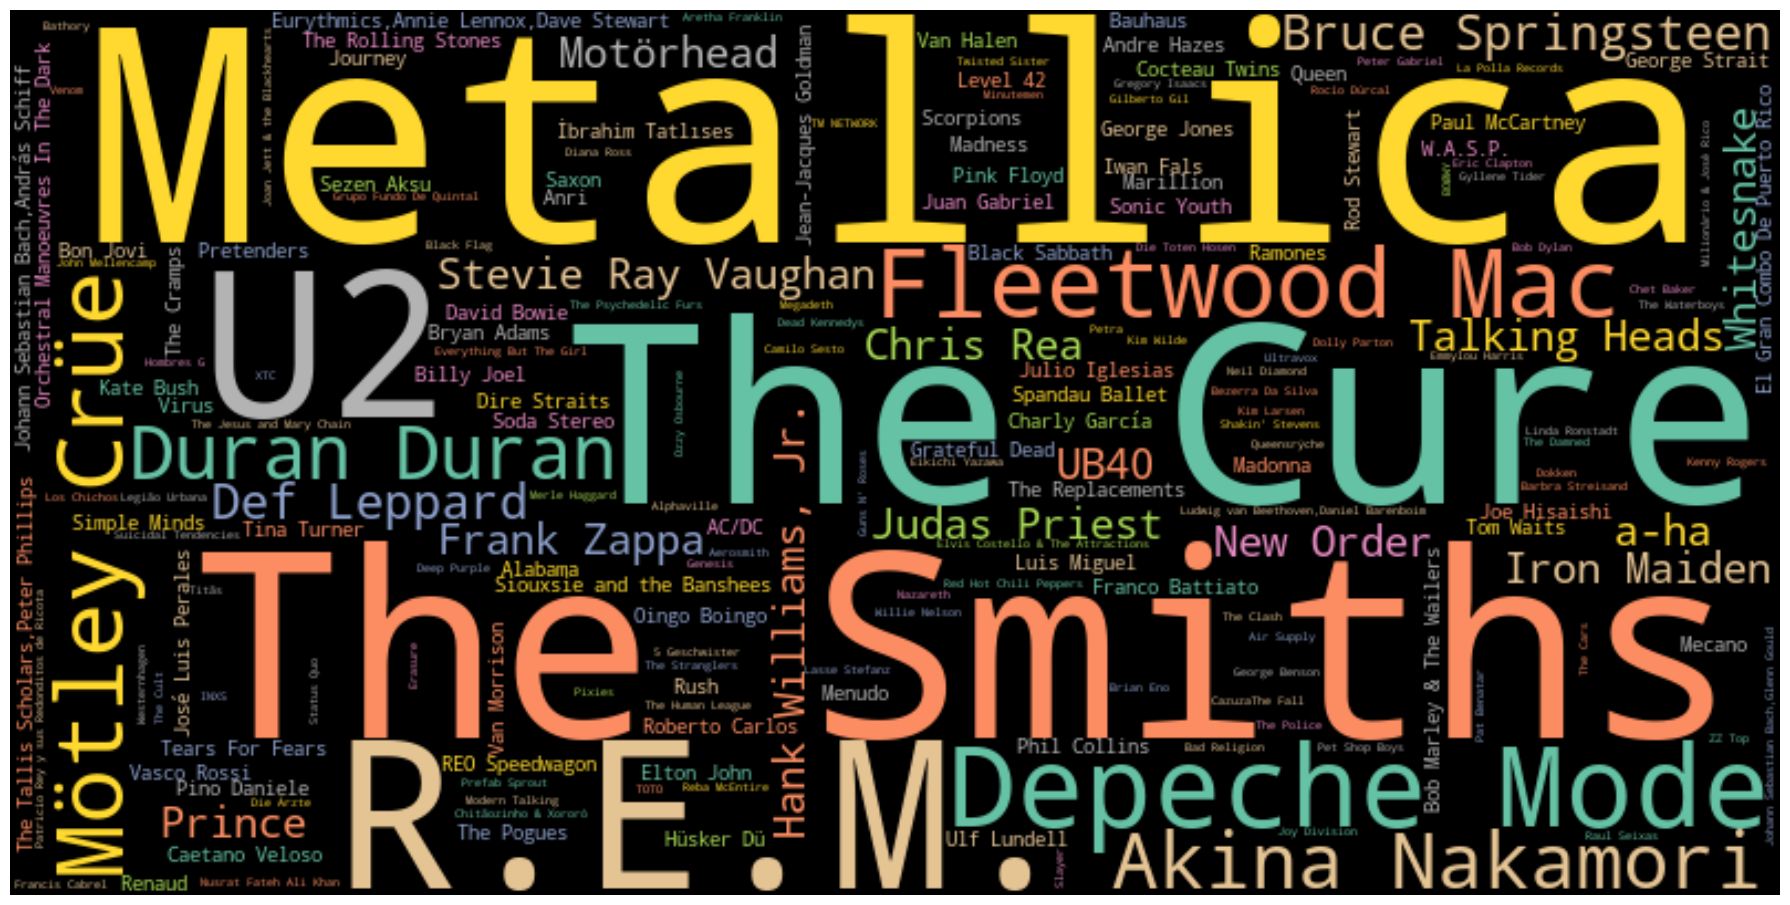

In [309]:
artist_popularity_tuples = [tuple(x) for x in artists_popularity.values]
wordcloud_artists(dict(artist_popularity_tuples))

### Artists with Top Popularity per Year

In [ ]:
top_artist = df.groupby(['year', 'artists'])['popularity'].sum().reset_index()

In [366]:
artist_year = df.groupby(['year', 'artists'])['popularity'].sum().reset_index()

In [367]:
top_artists = artist_year.groupby('year')['popularity', 'artists'].apply(lambda x: x.nlargest(5, 'popularity')).reset_index(drop=False)


In [339]:
top_artists=top_artists.drop(columns="level_1")

In [348]:
top_artists

,year,popularity,artists
0,1980,2255,Alabama
1,1980,1657,Pance F. Pondaag
2,1980,1362,Pretenders
3,1980,1307,Joy Division
4,1980,1172,The Clash
5,1981,1583,"Wolfgang Amadeus Mozart,András Schiff"
6,1981,1258,"Johann Sebastian Bach,Glenn Gould"
7,1981,1107,Frank Zappa
8,1981,1000,Joan Jett & the Blackhearts
9,1981,945,Mötley Crüe


In [357]:
fig = px.bar(top_artists[0:25], x='year', y='popularity', color='artists', barmode='group')
fig.show()